In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

E:\anoconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
E:\anoconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\anoconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\anoconda\envs\tensorflow\lib\site-packages\tensorflow\pytho

In [2]:
feanum=8
window=5
df2=pd.read_csv('data.csv') 
df1=df2.iloc[:,1:]
df1.tail()

,open,high,low,upstop,downstop,volume,money,close
2499,15.63,17.31,15.60,17.31,14.17,1.284608e+09,77134083,17.31
2500,16.80,18.25,16.30,19.04,15.58,-1.523133e+09,160122322,17.07
2501,17.40,17.55,15.41,18.78,15.36,1.863823e+09,112160475,16.15
2502,15.46,15.70,14.54,17.77,14.54,1.557303e+09,103132425,14.56
2503,14.56,16.02,14.56,16.02,13.10,1.606830e+09,105398538,16.02


In [3]:
rate_origin=df1['close']

In [4]:
df=(df1-df1.min())/(df1.max()-df1.min())
df.tail()

,open,high,low,upstop,downstop,volume,money,close
2499,0.884252,0.941562,0.950832,0.896537,0.896949,0.505236,0.185197,1.000000
2500,0.960763,1.000000,1.000000,1.000000,1.000000,0.000000,0.385611,0.984212
2501,1.000000,0.956482,0.937487,0.984451,0.983921,0.609463,0.269785,0.923693
2502,0.873135,0.841470,0.876378,0.924048,0.923991,0.554306,0.247982,0.819100
2503,0.814280,0.861364,0.877783,0.819389,0.818748,0.563218,0.253455,0.915142


In [5]:
#加载keras模块
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import keras
from keras.utils import np_utils
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [6]:
def load_data(stock, seq_len):#输入data表格
    amount_of_features = len(stock.columns)#有几列
    data = stock.as_matrix() #pd.DataFrame(stock) 讲表格转化为矩阵
    sequence_length = seq_len + 1#序列长度5+1
    result = []
    for index in range(len(data) - sequence_length):#循环170-5次
        result.append(data[index: index + sequence_length])#第i行到i+5行

    result = np.array(result)#得到161个样本，样本形式为6天*3特征
    row = round(0.9 * result.shape[0])#划分训练集测试集
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
#reshape成 5天*3特征
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [7]:
def build_model2(layers):
        d = 0.1
        model = Sequential()
        model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(32,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [8]:
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2248, 5, 8)
y_train (2248,)
X_test (250, 5, 8)
y_test (250,)


E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# model = build_model([3,lag,1])
model = build_model2([feanum,window,1])

W0102 11:22:55.739288 13448 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0102 11:22:55.757241 13448 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 11:22:55.776280 13448 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0102 11:22:56.404953 13448 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0102 11:22:56.413930 13448 deprec

In [10]:
history = LossHistory()

In [11]:
model.fit(
    X_train,
    y_train,
    batch_size=1024,
    nb_epoch=50,
    validation_split=0.1,
    verbose=0,
    callbacks=[history])

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0102 11:22:57.455006 13448 deprecation.py:323] From E:\anoconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0102 11:22:58.667227 13448 deprecation_wrapper.py:119] From E:\anoconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



在测试集和验证集上的loss/acc下降情况


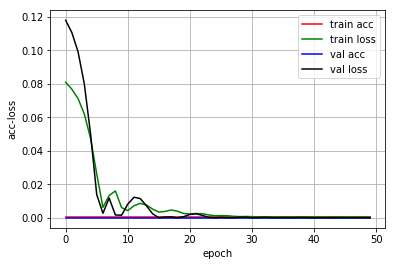

In [12]:
print('在测试集和验证集上的loss/acc下降情况')
history.loss_plot('epoch')

In [13]:
y_train_predict=model.predict(X_train)[:,0]
y_train=y_train#[:,0]

在训练集上的表现:


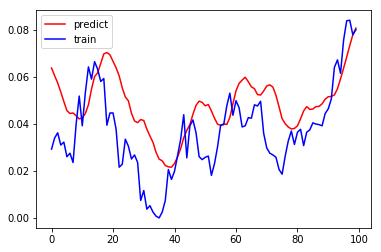

In [14]:
plt.plot(y_train_predict[100:200],color='red', label='predict')
plt.plot(y_train[100:200],color='blue', label='train')
plt.legend(loc='upper left')
print('在训练集上的表现:')
plt.show()

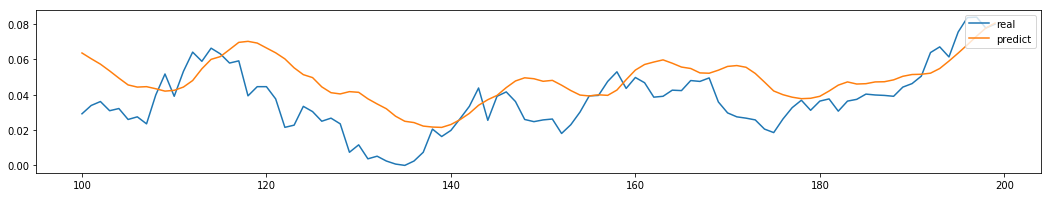

In [15]:
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[100:200,0].plot(figsize=(18,3))
draw.iloc[100:200,1].plot(figsize=(18,3))
plt.legend(('real', 'predict'),loc='upper right')
#展示在训练集上的表现 图更好看

In [16]:
y_test_predict=model.predict(X_test)[:,0]
y_test=y_test

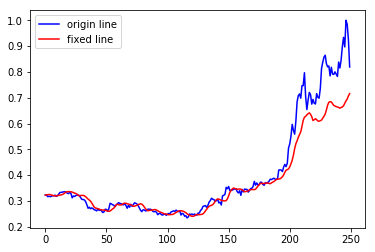

In [17]:
plt.plot(y_test, 'b', label='origin line')
plt.plot(y_test_predict, 'r', label='fixed line')
plt.legend()
plt.show()
#展示在测试集上的表现 

Text(0.5,1,'LSTM')

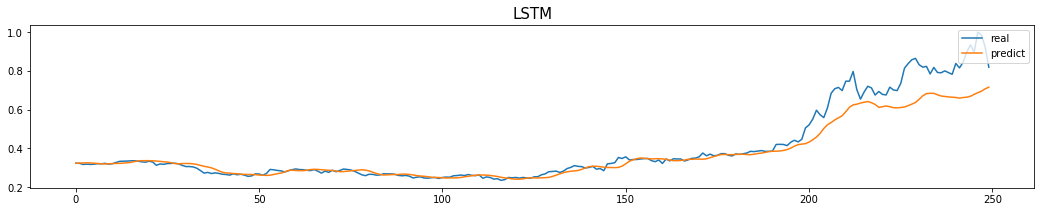

In [22]:
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[:,0].plot(figsize=(18,3))
draw.iloc[:,1].plot(figsize=(18,3))
plt.legend(('real', 'predict'),loc='upper right')
plt.title("LSTM",fontsize='15') #添加标题
#展示在测试集上的表现 图更好看

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(model.predict(X_train), y_train))
print(mean_squared_error(model.predict(X_train), y_train) )
#训练集上的MAE和MSE

0.014425015117331142
0.0004462699850230015


In [20]:
print(mean_absolute_error(model.predict(X_test), y_test))
print(mean_squared_error(model.predict(X_test), y_test) )
#测试集上的MAE和MSE

0.03636890417618233
0.004857504362045099


In [21]:
y_var_test=y_test[1:]-y_test[:len(y_test)-1]
y_var_predict=y_test_predict[1:]-y_test_predict[:len(y_test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test-1)):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('预测涨跌正确:',result)

预测涨跌正确: 0.5020080321285141
